In [121]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,5)
plt.rcParams['figure.dpi'] = 300
import os
import torch.optim
import scipy.io
from torch import nn
from torch.utils.data import Dataset, DataLoader
master_dir = os.getcwd()
# For loading my own script:
%load_ext autoreload
%autoreload 2
import assignment3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Principal Component Analysis

## Explore the data and the sizes of eigenvalues

In [179]:
dim = 50
nb_points = 500
x = assignment3.generate_data(dim, nb_points)
mean = np.mean(x, axis=1)

Compute the covariance matrix and its eigenvectors and values:

In [173]:
cov = np.cov(x)
eig_vals, eig_vectors = np.linalg.eig(cov)
# Sort eig vals and eig vectors for convencience of plotting
sort_indices = np.argsort(-eig_vals)
eig_vals_sorted = eig_vals[sort_indices]
eig_vectors_sorted = eig_vectors[sort_indices]

Show the eigenvalues

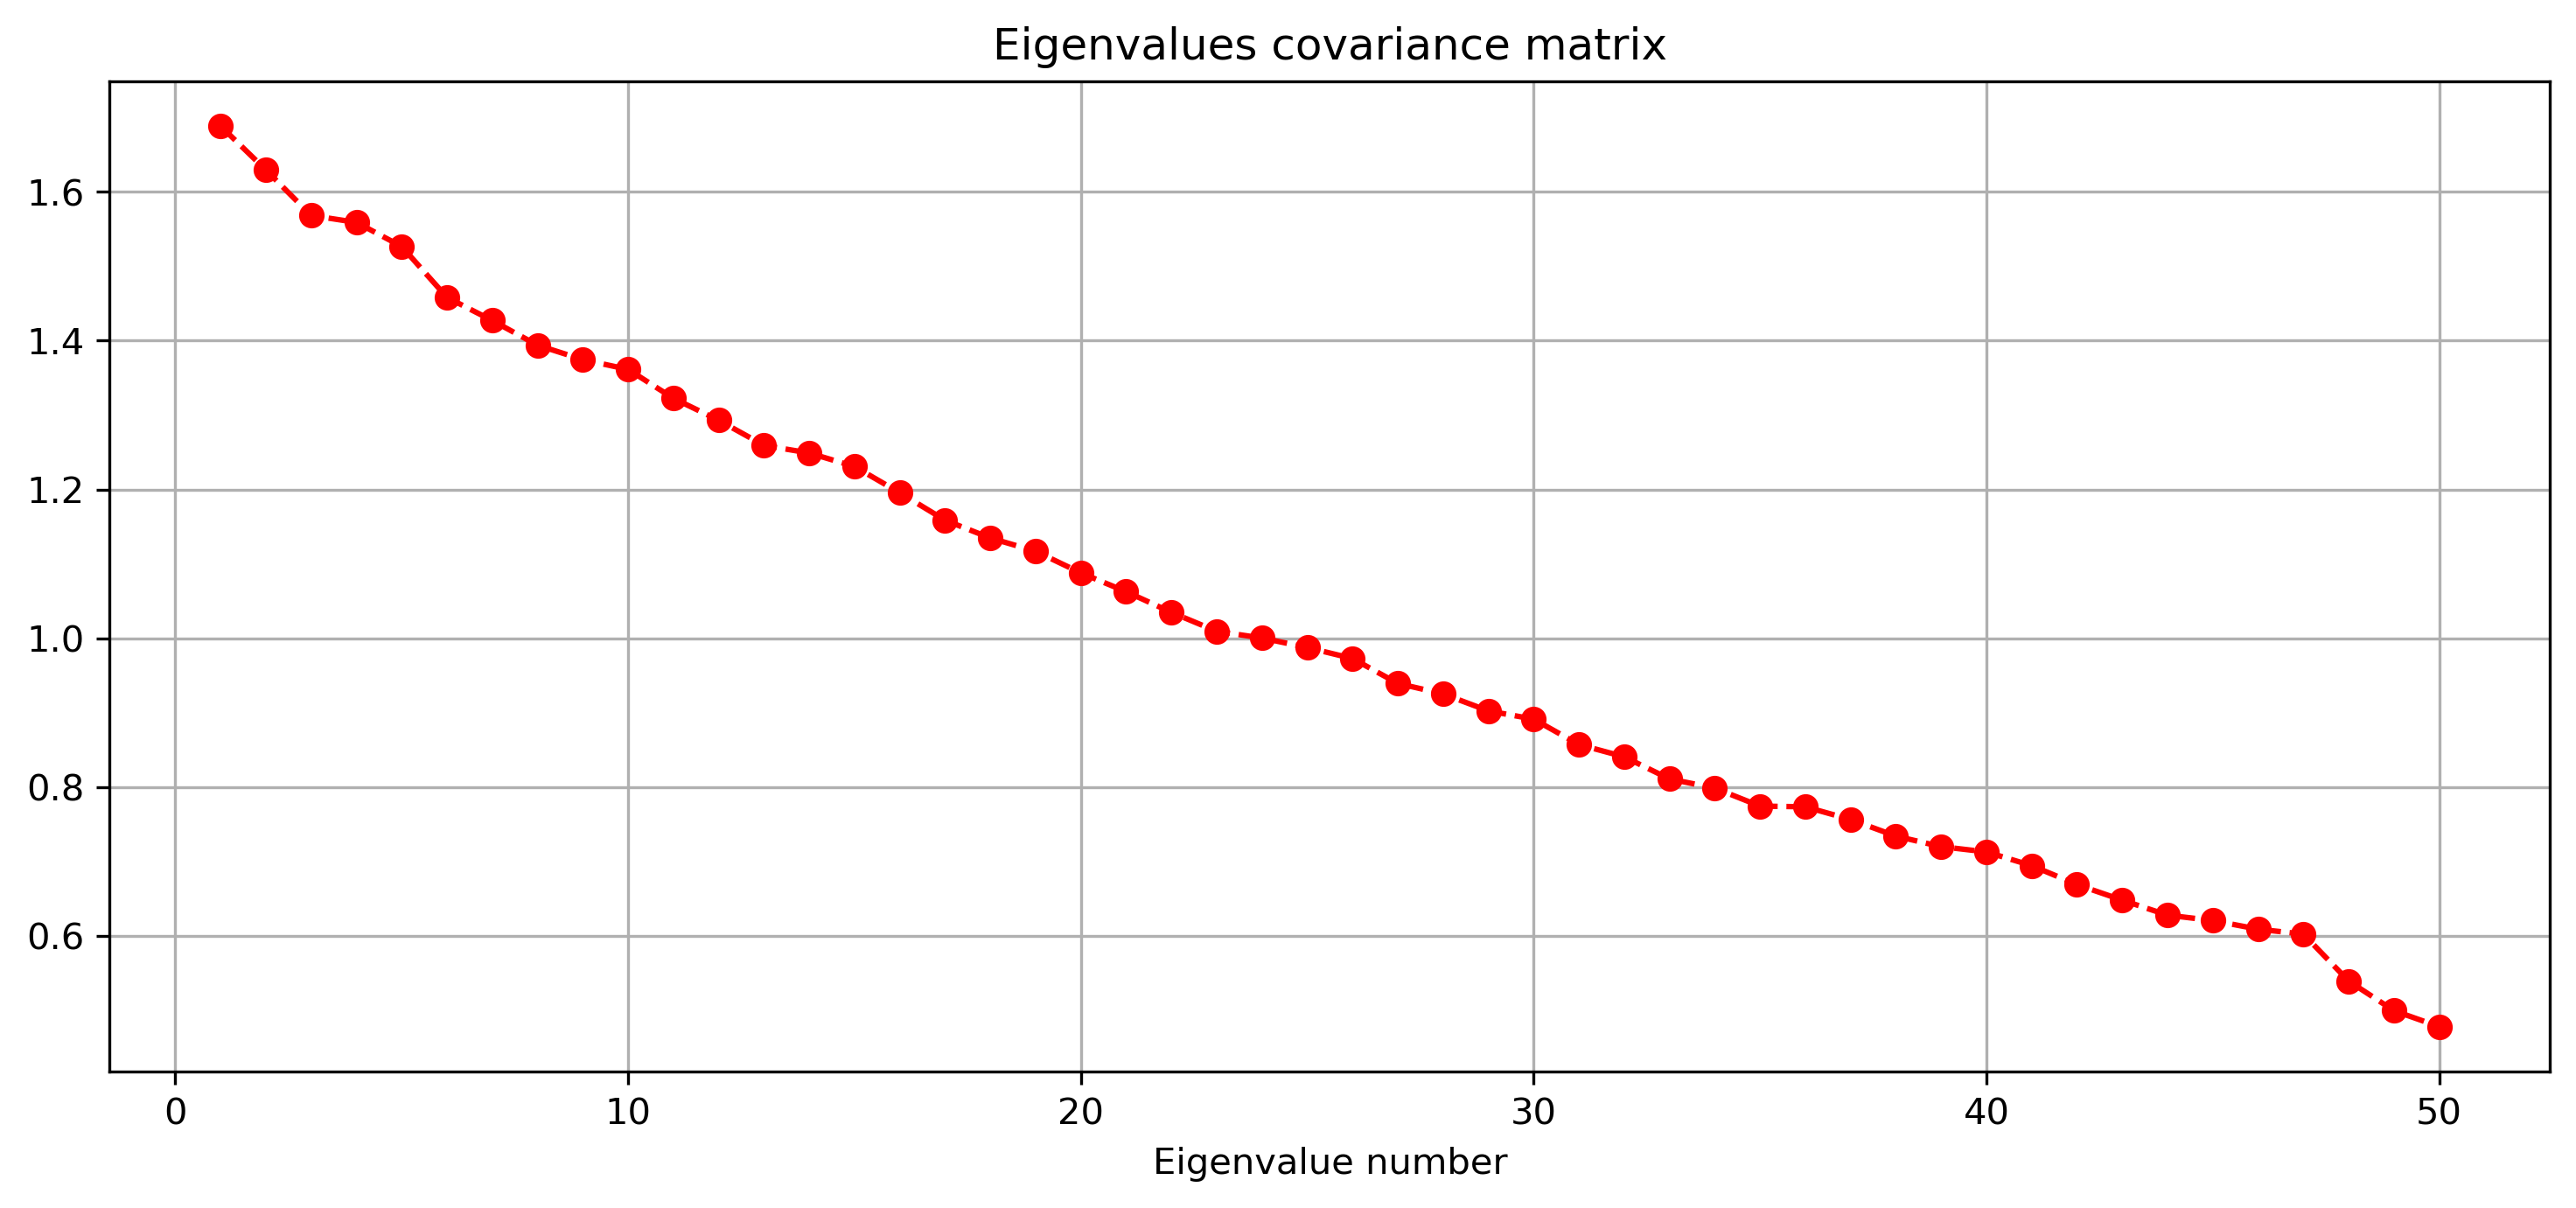

In [124]:
plt.plot([i+1 for i in range(len(eig_vals_sorted))], eig_vals_sorted, '--o', color='red')
plt.grid()
plt.xlabel("Eigenvalue number")
plt.title("Eigenvalues covariance matrix")
plt.show()

Determine q, the number of eigenvalues we retain. We define a threshold $0 < t <1$ and keep all eigenvalues for which the cumulative sum is below $t\cdot S$, with $S = \sum_i \lambda_i$ being the sum of all eigenvalues.

In [125]:
cumsum = np.cumsum(eig_vals_sorted)
threshold = 0.75
filter_result = np.where(cumsum < threshold*cumsum[-1], 1, 0)
filter_result

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [126]:
q = np.sum(filter_result)
print(f"The reduced dimension is {q}")

The reduced dimension is 31


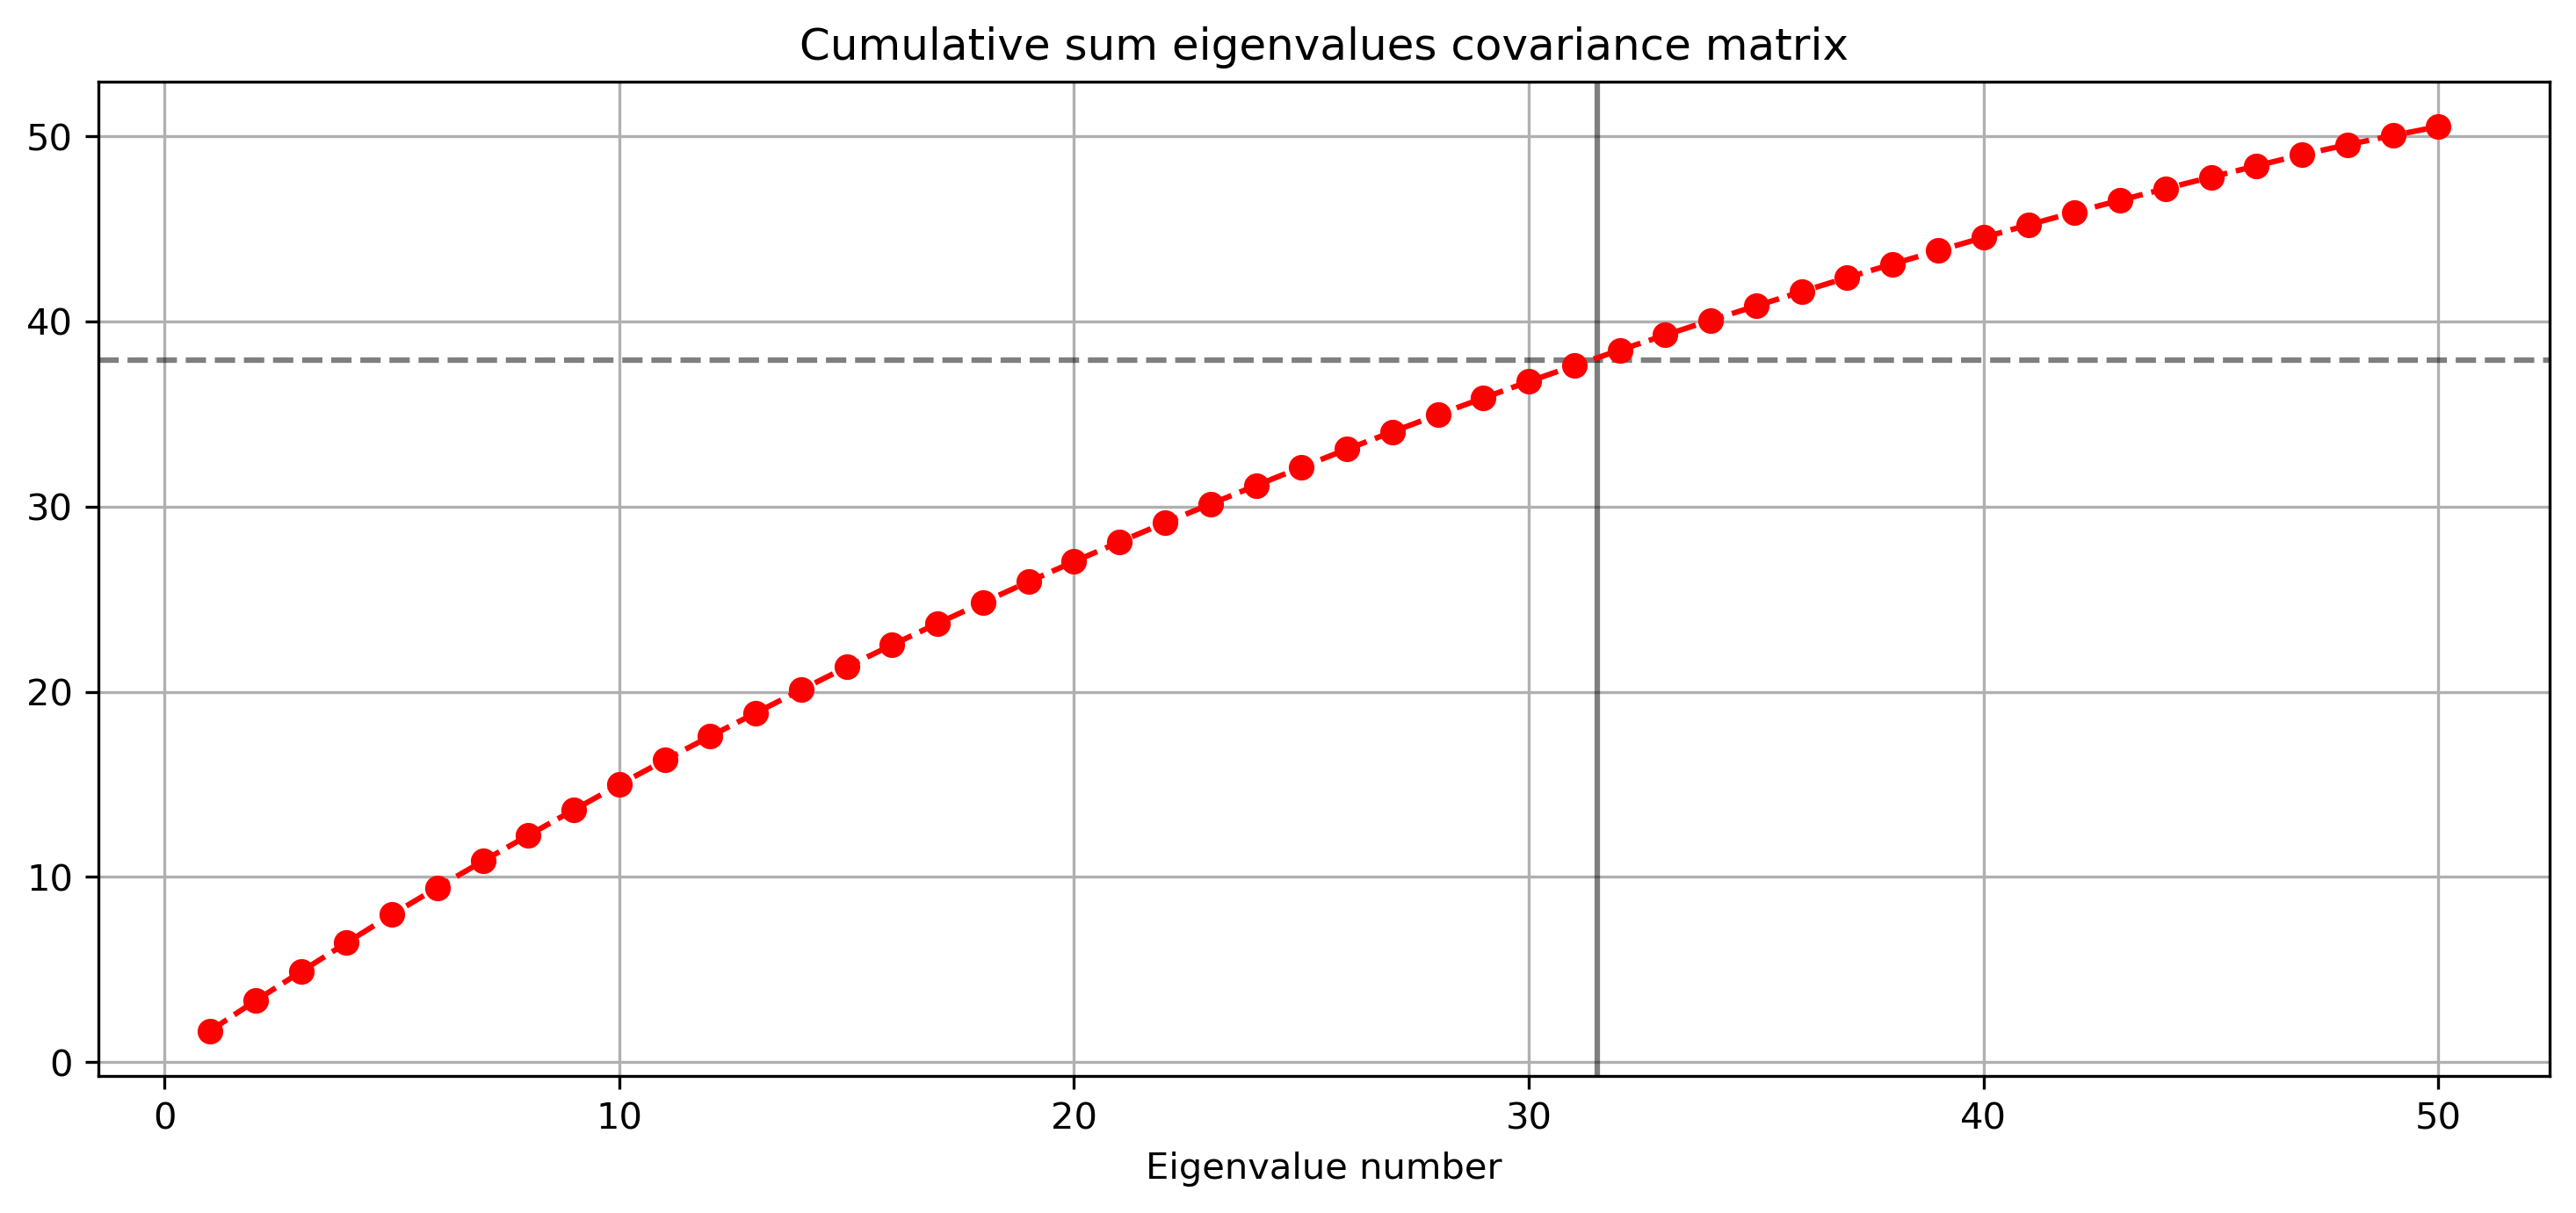

In [128]:
plt.plot([i+1 for i in range(len(cumsum))], cumsum, '--o', color='red', zorder=100)
plt.axhline(threshold*cumsum[-1], ls="--", color="black", alpha=0.5)
plt.axvline(q+0.5, color="black", alpha=0.5)
plt.grid()
plt.xlabel("Eigenvalue number")
plt.title("Cumulative sum eigenvalues covariance matrix")
plt.show()

## Perform PCA

Do a single PCA (to test the code)

In [193]:
x = assignment3.generate_data(dim, nb_points)
print(np.shape(x)[1])
x_hat, q = assignment3.pca(x, 0.6)
rmsd = assignment3.compute_rmsd(x, x_hat)
rmsd

500
The reduced dimension is 23


0.0008336736676074419

Iterate over various threshold values:

In [207]:
# Generate a dataset
x = assignment3.generate_data(dim, nb_points)
threshold_list = np.arange(0.1, 1, 0.05)
rmsd_list = []
q_list = []
for t in threshold_list:
    x_hat, q = assignment3.pca(x, t)
    rmsd = assignment3.compute_rmsd(x, x_hat)
    rmsd_list.append(rmsd)
    q_list.append(q)
best_index = np.argmin(rmsd_list)

The reduced dimension is 3
The reduced dimension is 4
The reduced dimension is 6
The reduced dimension is 8
The reduced dimension is 10
The reduced dimension is 12
The reduced dimension is 14
The reduced dimension is 16
The reduced dimension is 18
The reduced dimension is 20
The reduced dimension is 23
The reduced dimension is 25
The reduced dimension is 28
The reduced dimension is 31
The reduced dimension is 34
The reduced dimension is 37
The reduced dimension is 41
The reduced dimension is 45


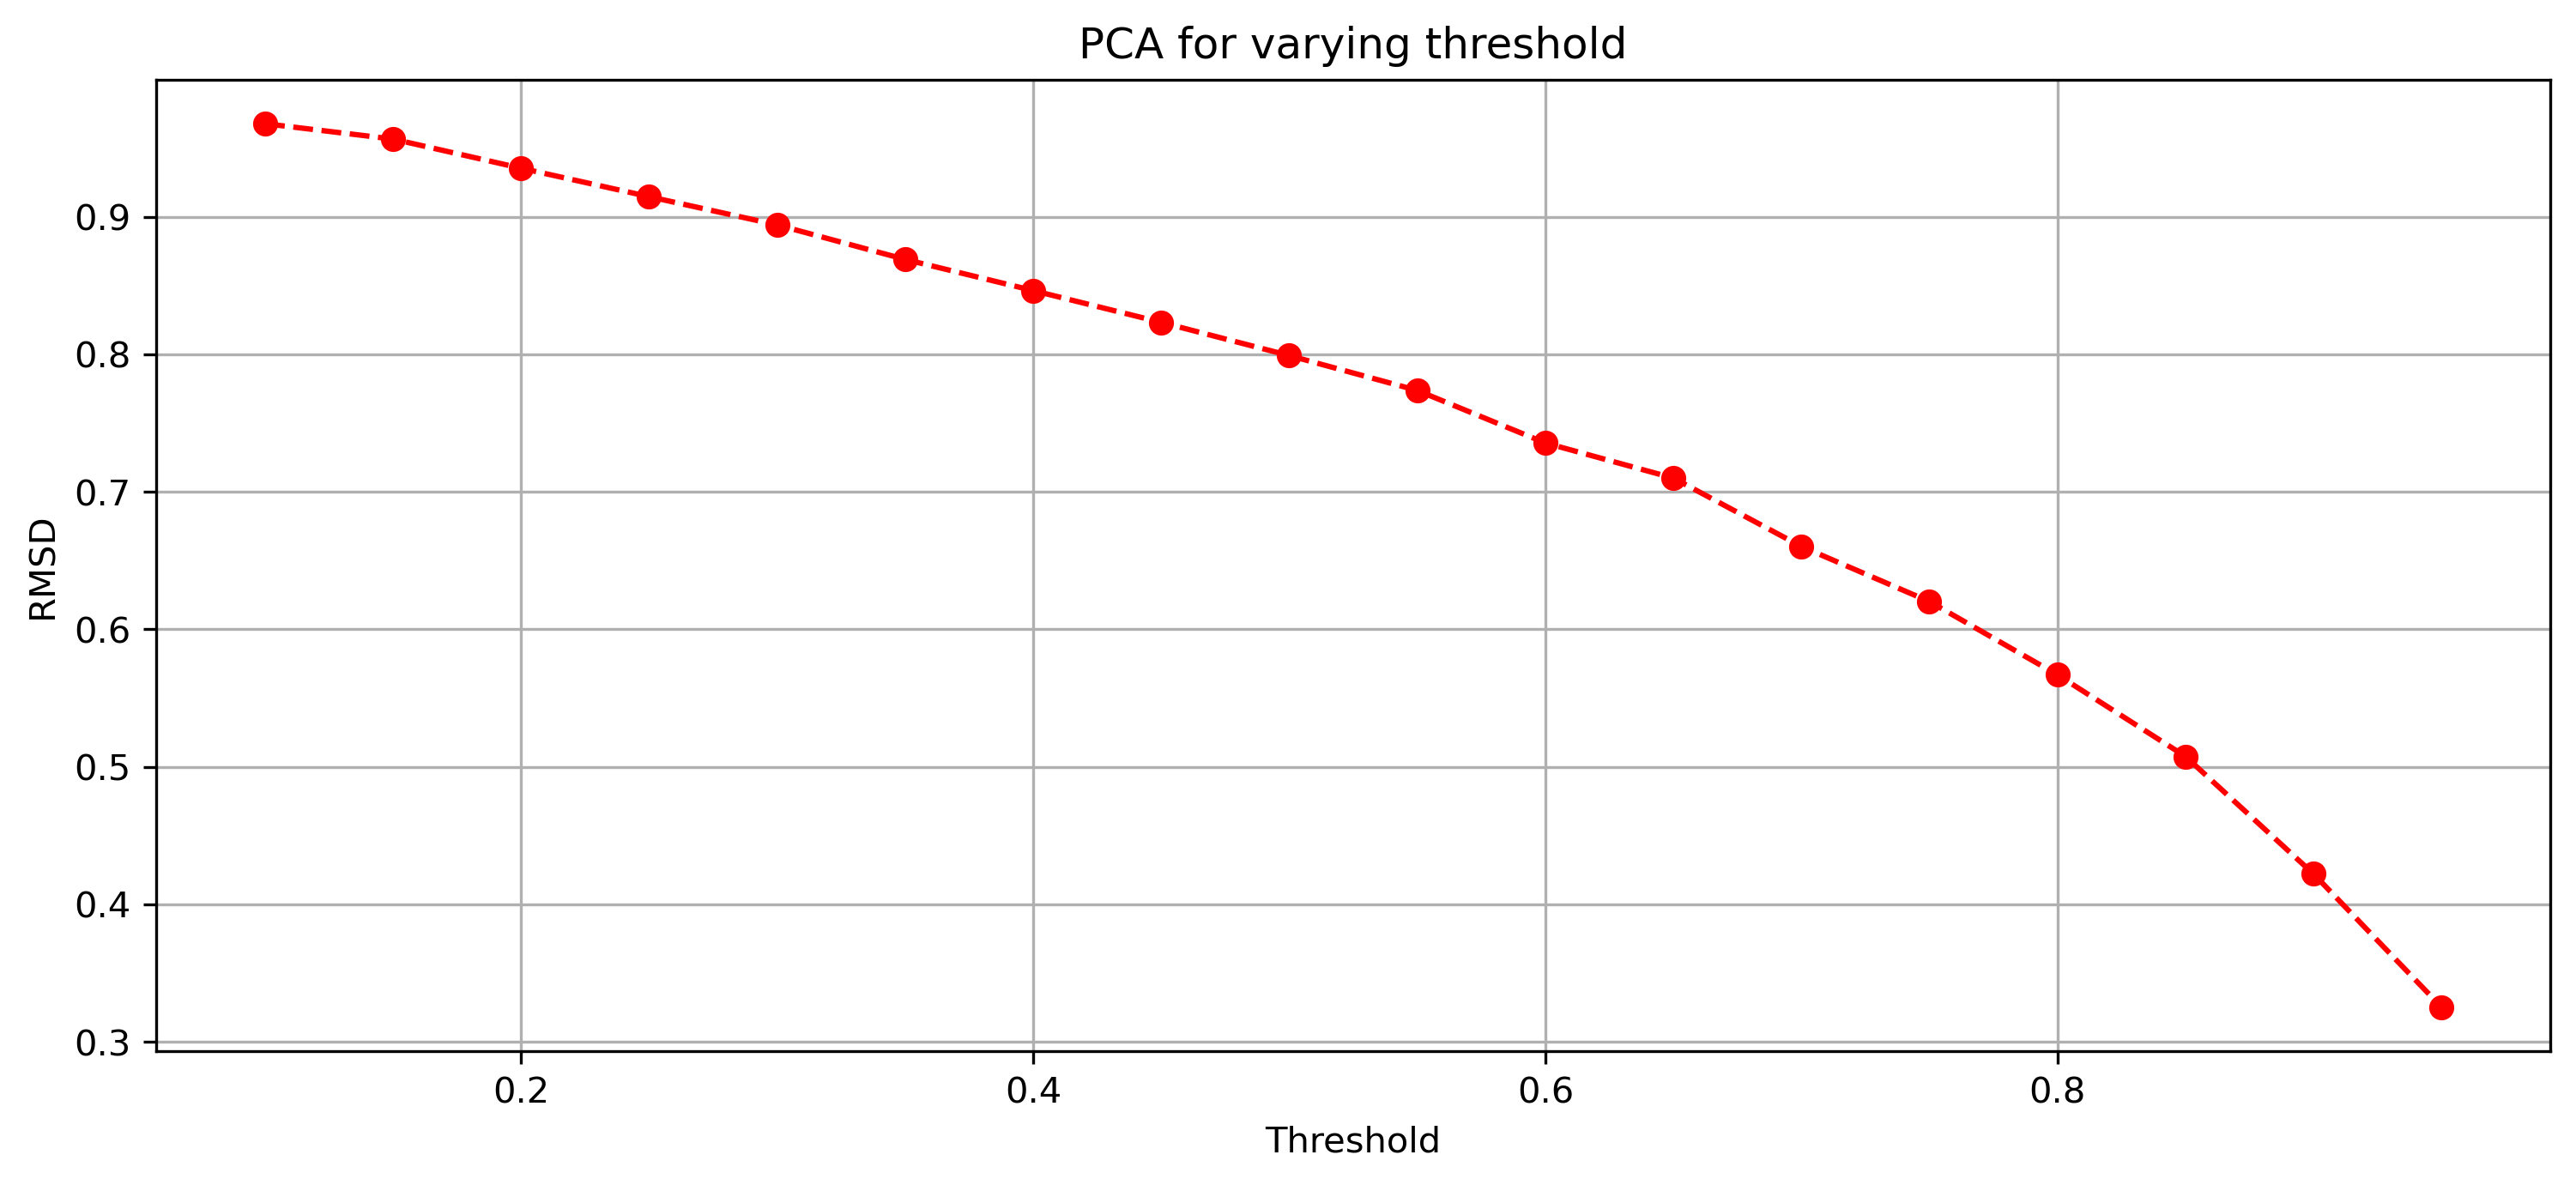

In [214]:
plt.plot(threshold_list, rmsd_list, '--o', color='red')
plt.grid()
# plt.axhline(rmsd_list[best_index], color='black', alpha=0.5)
# plt.axvline(threshold_list[best_index], color='black', alpha=0.5)
plt.xlabel("Threshold")
plt.ylabel("RMSD")
plt.title("PCA for varying threshold")
plt.show()

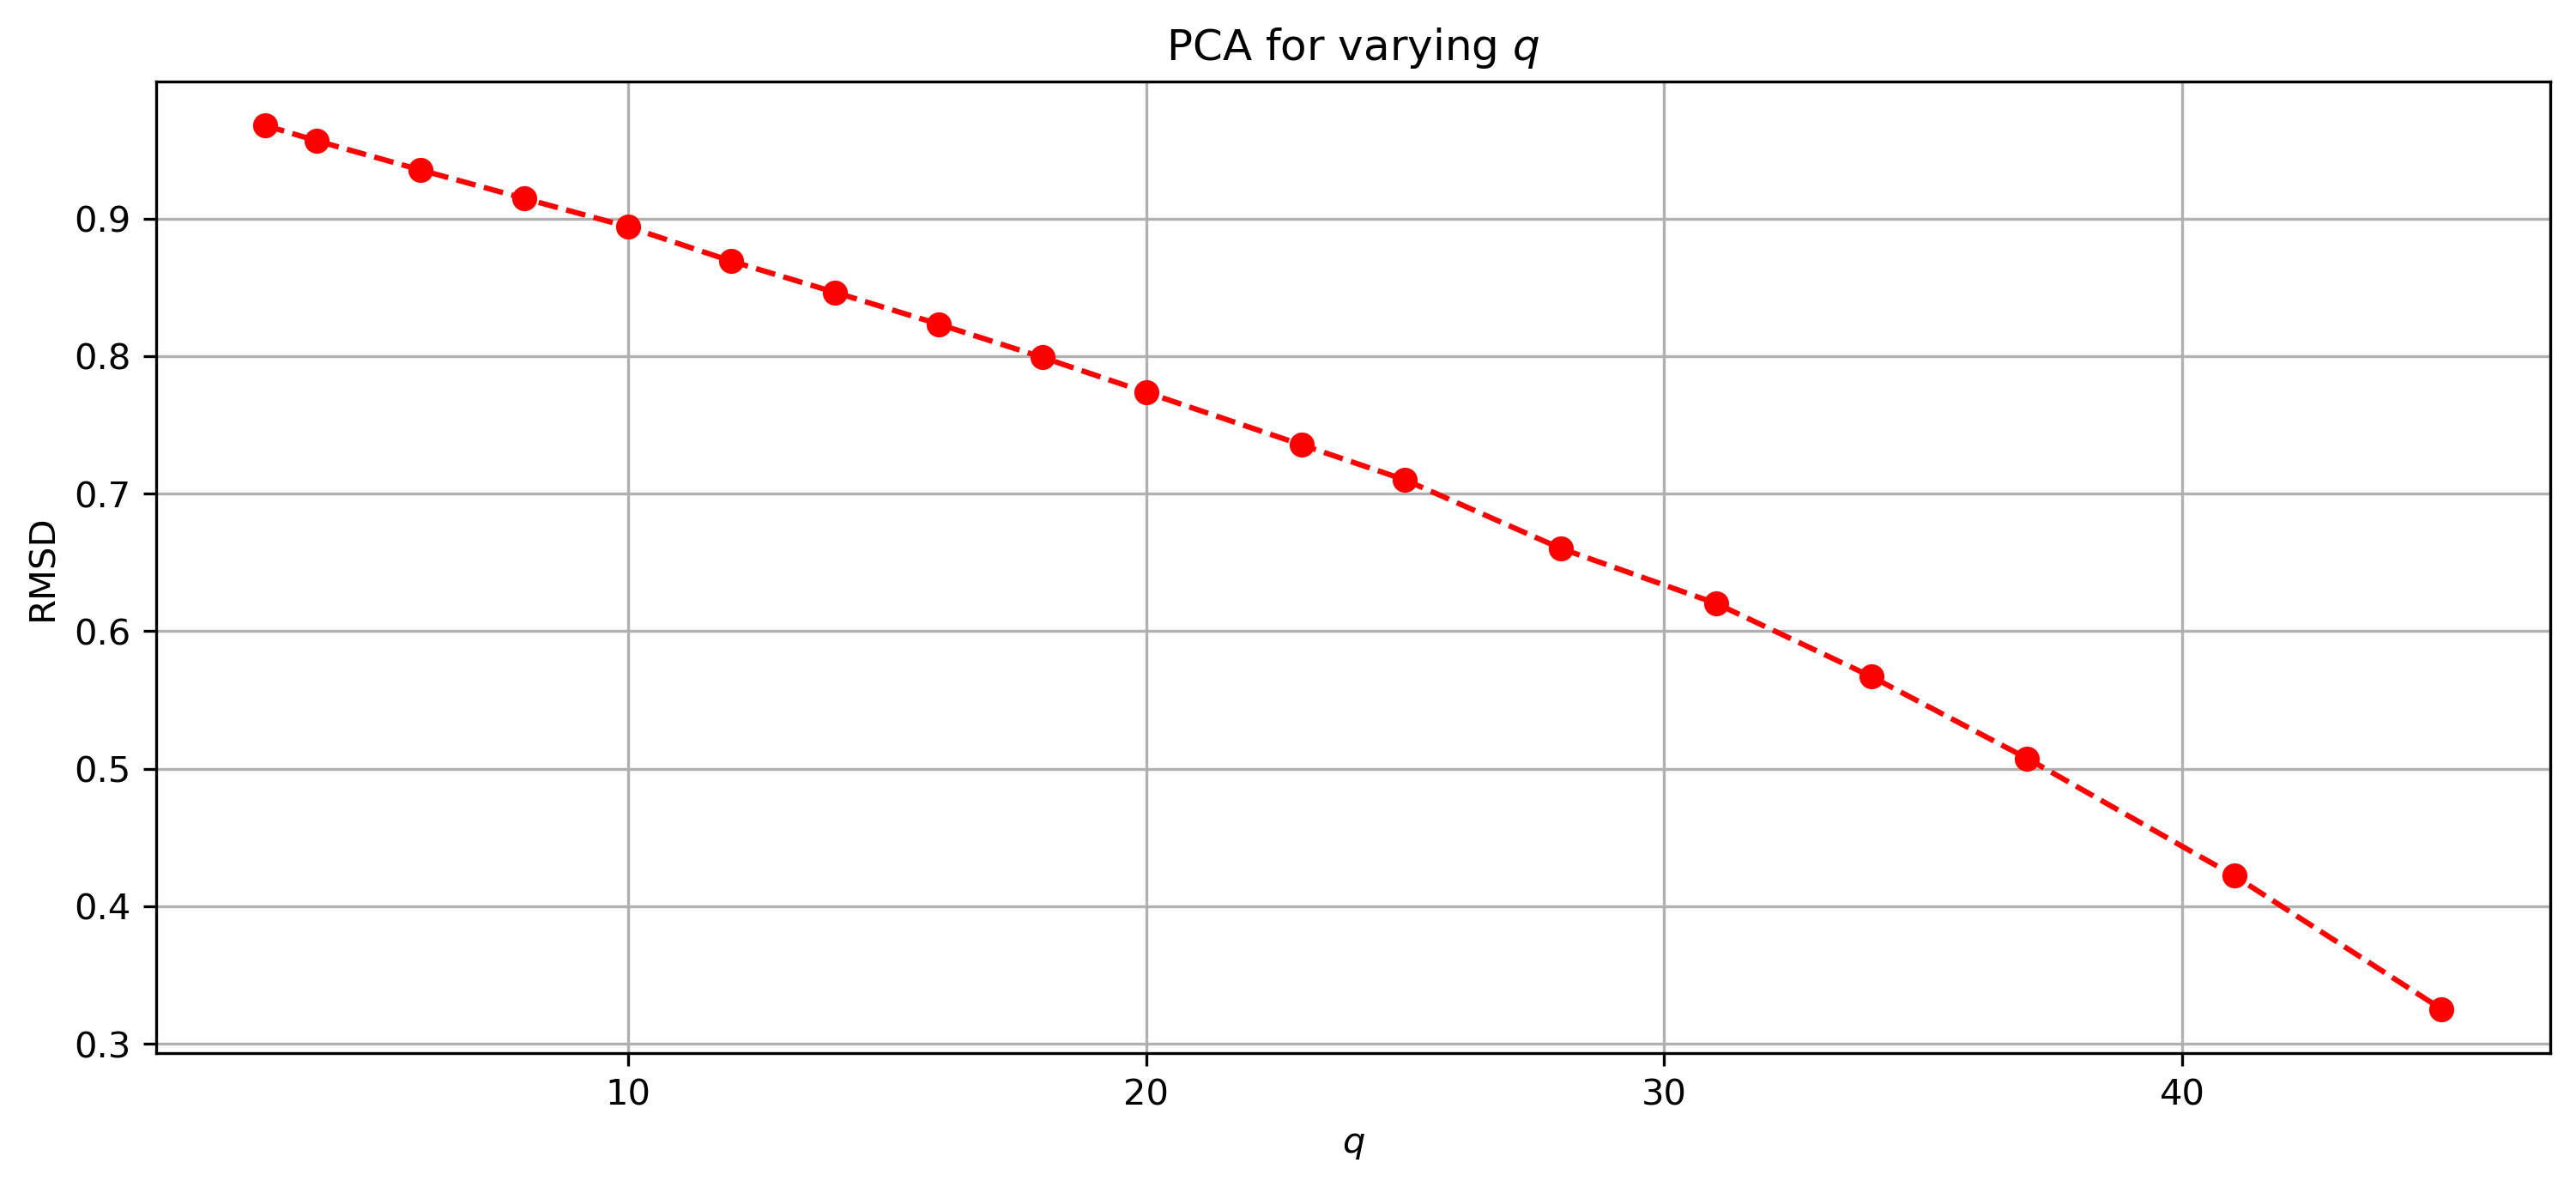

In [212]:
plt.plot(q_list, rmsd_list, '--o', color='red')
plt.grid()
# plt.axhline(rmsd_list[best_index], color='black', alpha=0.5)
# plt.axvline(q_list[best_index], color='black', alpha=0.5)
plt.xlabel(r"$q$")
plt.ylabel("RMSD")
plt.title(r"PCA for varying $q$")
plt.show()

## PCA on handwritten digits

Load the data: we transpose to have the same dimensions as in the exercise above:

In [266]:
# threes = scipy.io.loadmat(os.path.join(master_dir, "Files/threes.mat"))
threes = np.transpose(np.loadtxt(os.path.join(master_dir, "Files/threes.mat")))
print(np.shape(threes))

(256, 500)


Visualize a few threes:

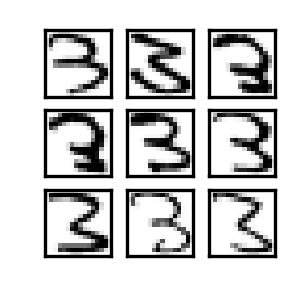

In [267]:
# plt.figure(figsize = (2, 2))
fig, axs = plt.subplots(3, 3, figsize=(1, 1))
for i in range(9):
    ax = axs[i//3, i%3]
    img = np.rot90(threes[:, i].reshape(16, 16))
    ax.imshow(img, cmap="Greys")
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [268]:
# Subtract the mean
threes_normalized = np.copy(threes)
threes_mean = np.mean(threes, axis=1)
for i in range(np.shape(threes)[1]):
    threes_normalized[:, i] = threes_normalized[:, i] - threes_mean

Visualize the mean three

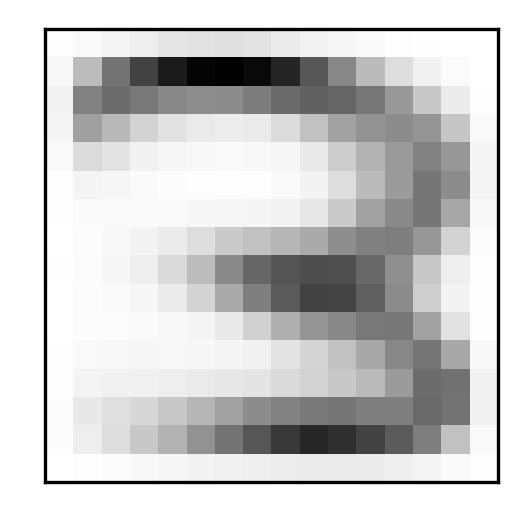

In [269]:
plt.figure(figsize = (2, 2))
img = np.rot90(threes_mean.reshape(16,16))
plt.imshow(img, cmap="Greys")
plt.xticks([])
plt.yticks([])
plt.show()

Visualize with the mean subtracted

In [ ]:
# plt.figure(figsize = (2, 2))
fig, axs = plt.subplots(3, 3, figsize=(1, 1))
for i in range(9):
    ax = axs[i//3, i%3]
    img = np.rot90(threes[:, i].reshape(16, 16))
    ax.imshow(img, cmap="Greys")
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

Compute the covariance matrix and its eigenvectors and values:

In [250]:
cov = np.cov(threes_normalized)
eig_vals, eig_vectors = np.linalg.eig(cov)
# Sort eig vals and eig vectors for convencience of plotting
sort_indices = np.argsort(-eig_vals)
eig_vals_sorted = eig_vals[sort_indices]
eig_vectors_sorted = eig_vectors[sort_indices]

Show the eigenvalues

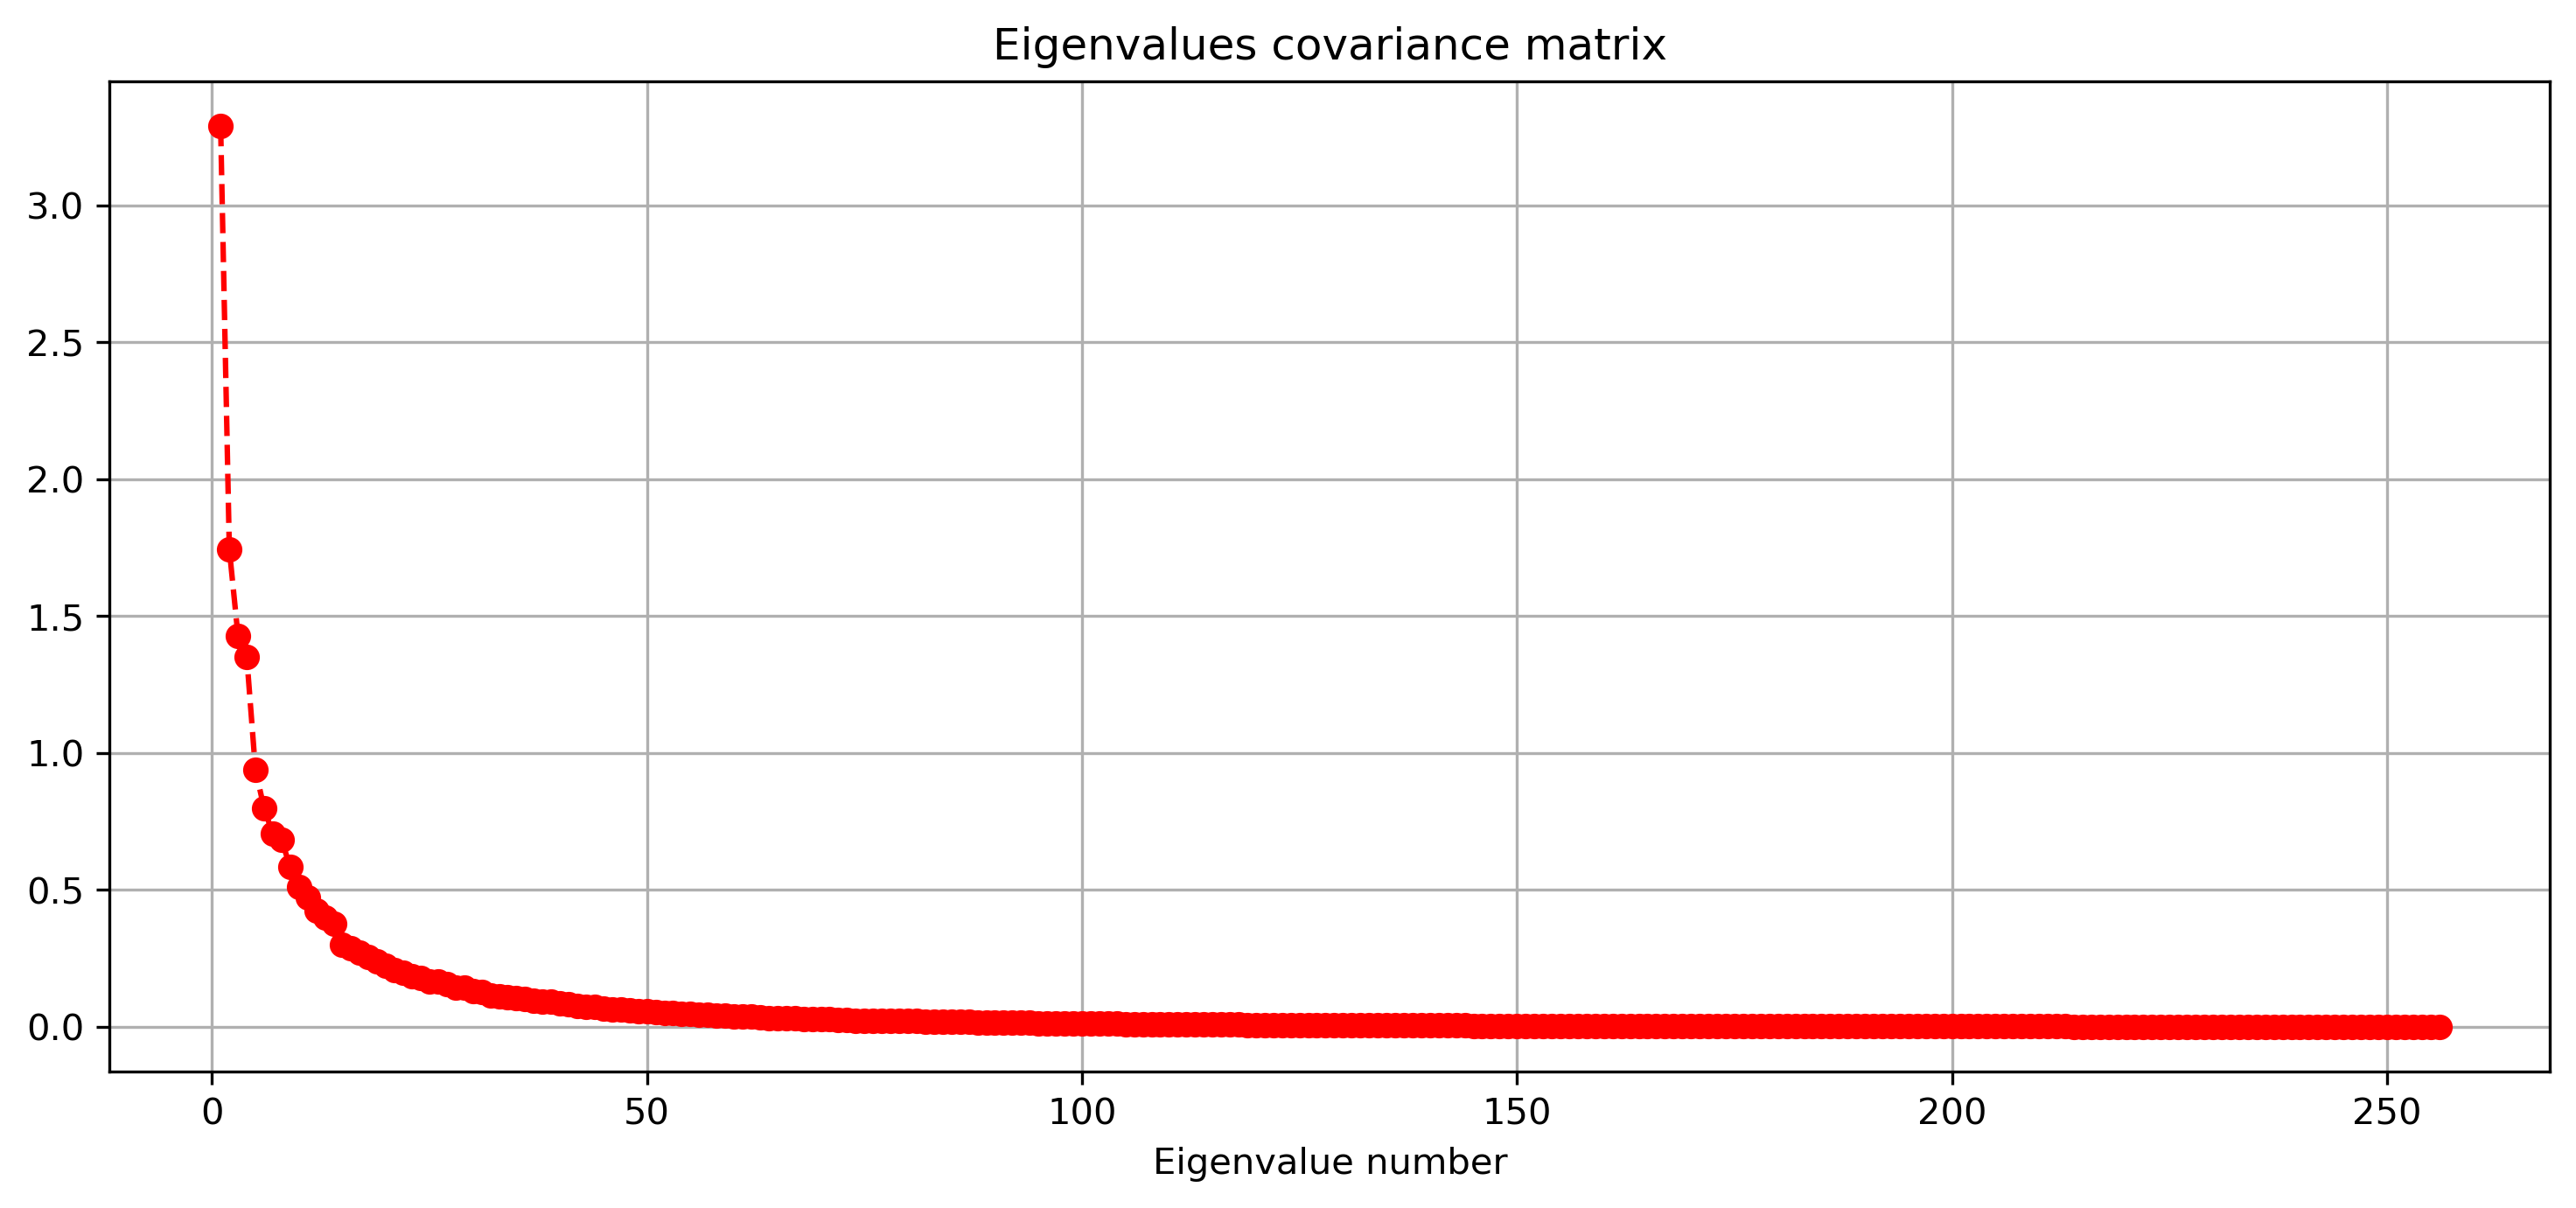

In [251]:
plt.plot([i+1 for i in range(len(eig_vals_sorted))], eig_vals_sorted, '--o', color='red')
plt.grid()
plt.xlabel("Eigenvalue number")
plt.title("Eigenvalues covariance matrix")
plt.show()

Determine q, the number of eigenvalues we retain. We define a threshold $0 < t <1$ and keep all eigenvalues for which the cumulative sum is below $t\cdot S$, with $S = \sum_i \lambda_i$ being the sum of all eigenvalues.

In [253]:
cumsum = np.cumsum(eig_vals_sorted)
threshold = 0.9
filter_result = np.where(cumsum < threshold*cumsum[-1], 1, 0)
filter_result

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [254]:
q = np.sum(filter_result)
print(f"The reduced dimension is {q}")

The reduced dimension is 44


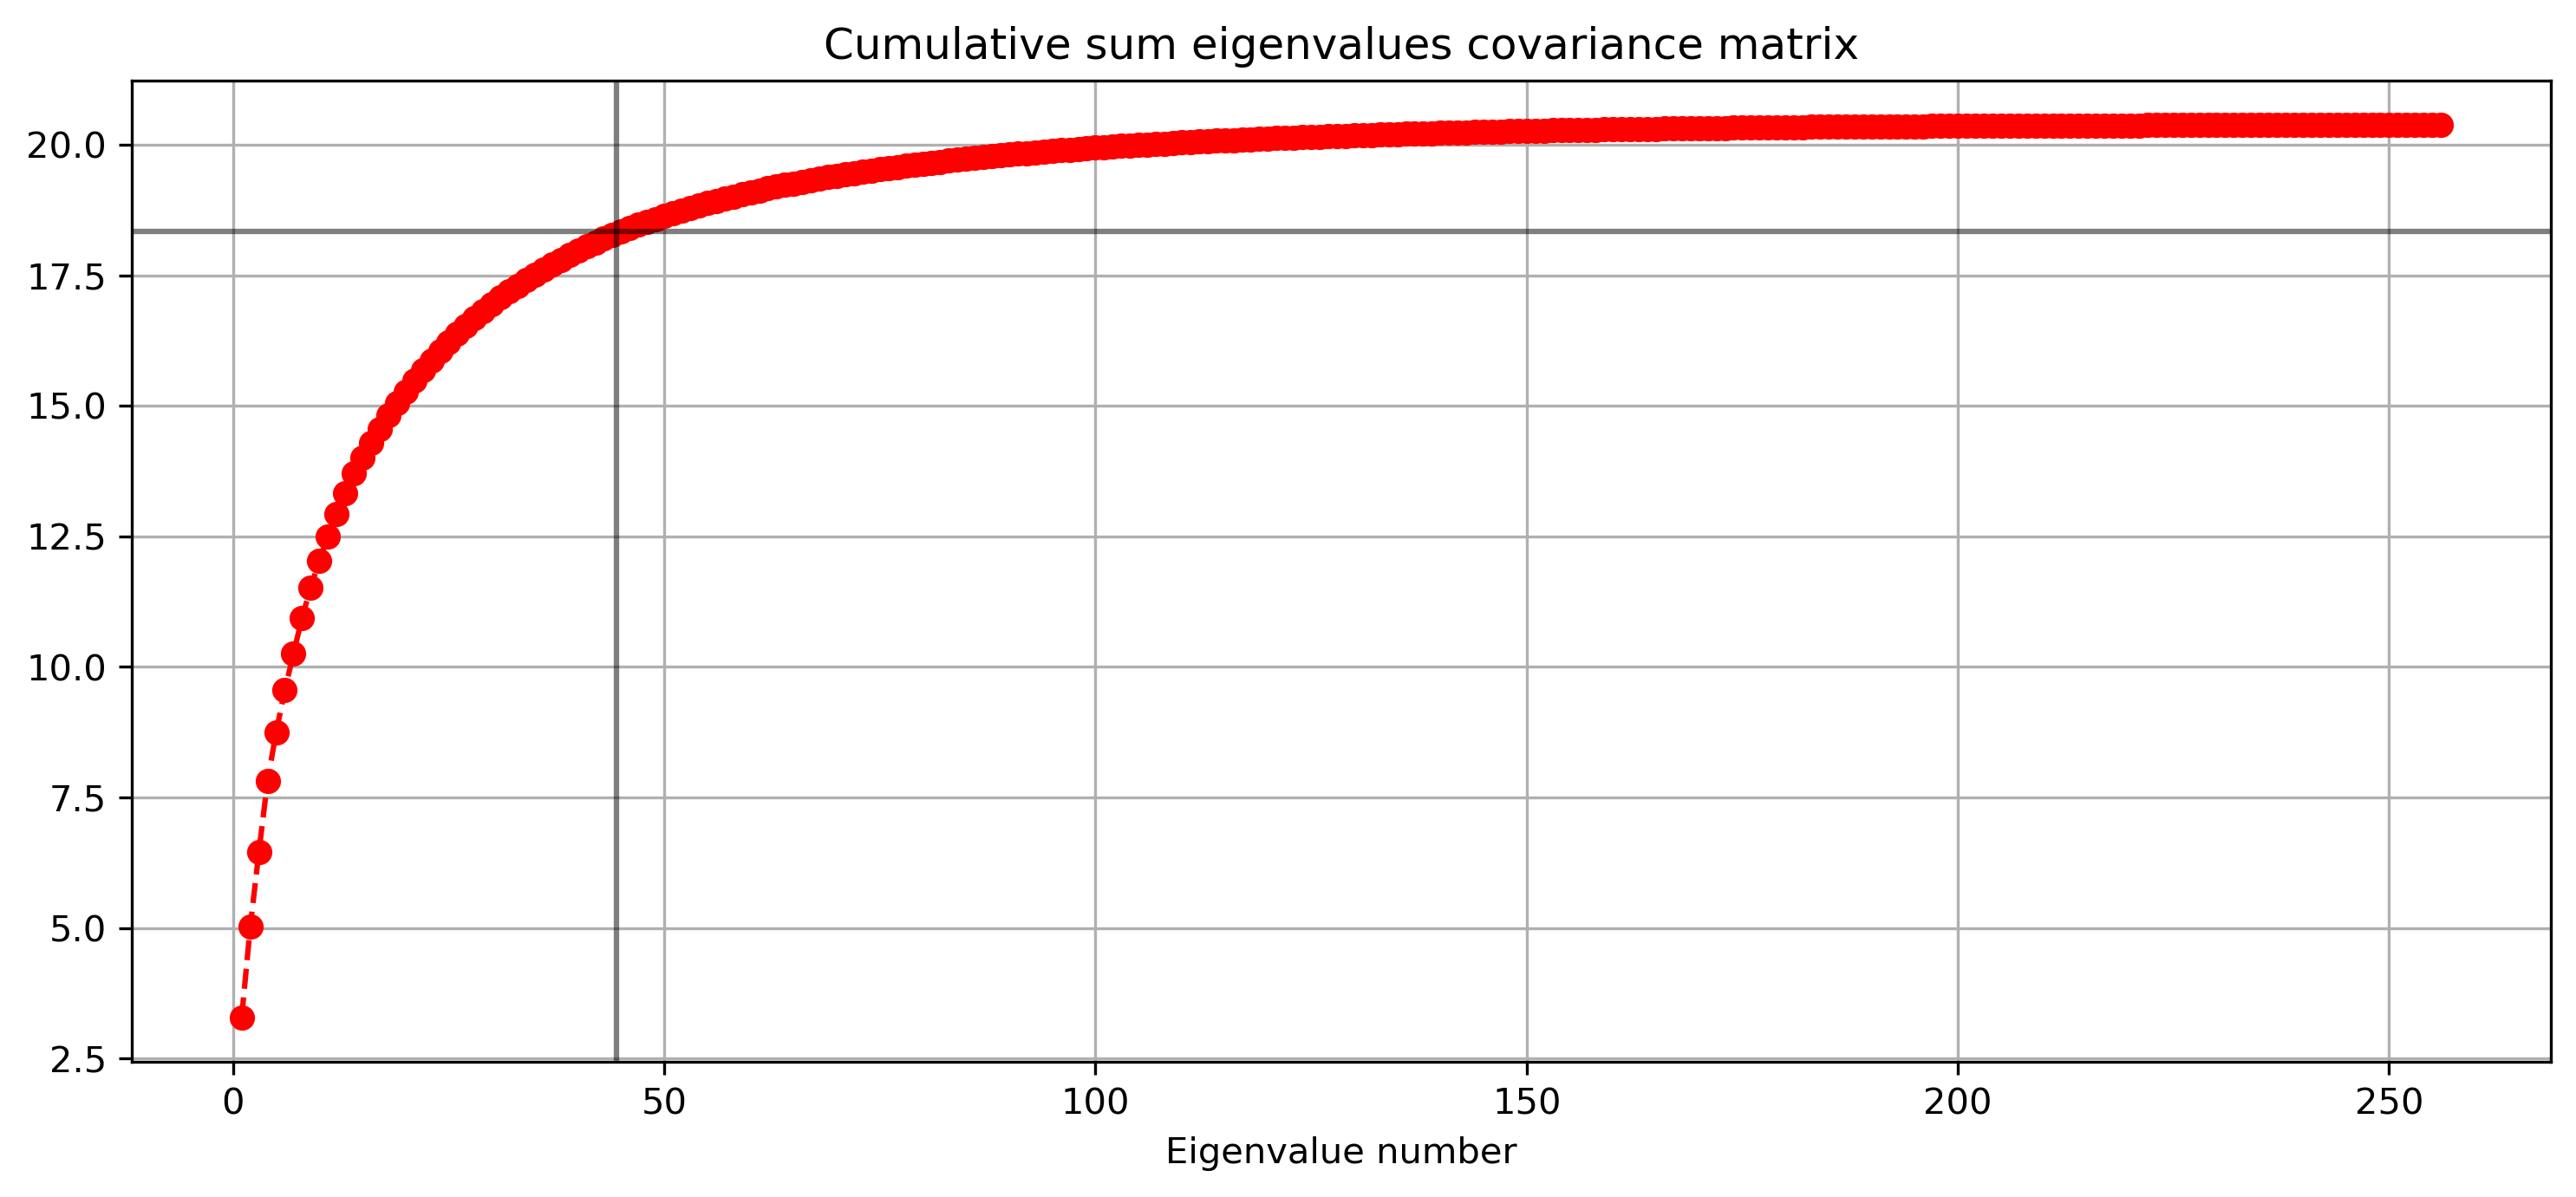

In [257]:
plt.plot([i+1 for i in range(len(cumsum))], cumsum, '--o', color='red')  # , zorder=100
plt.axhline(threshold*cumsum[-1], color="black", alpha=0.5)
plt.axvline(q+0.5, color="black", alpha=0.5)
plt.grid()
plt.xlabel("Eigenvalue number")
plt.title("Cumulative sum eigenvalues covariance matrix")
plt.show()

### PCA, get reconstructed images

In [271]:
q_list = [1, 2, 3, 4]
threes_hat_list = []
for i, q in enumerate(q_list):
    threes_hat = assignment3.pca_given_q(threes, q)
    threes_hat_list.append(threes_hat)

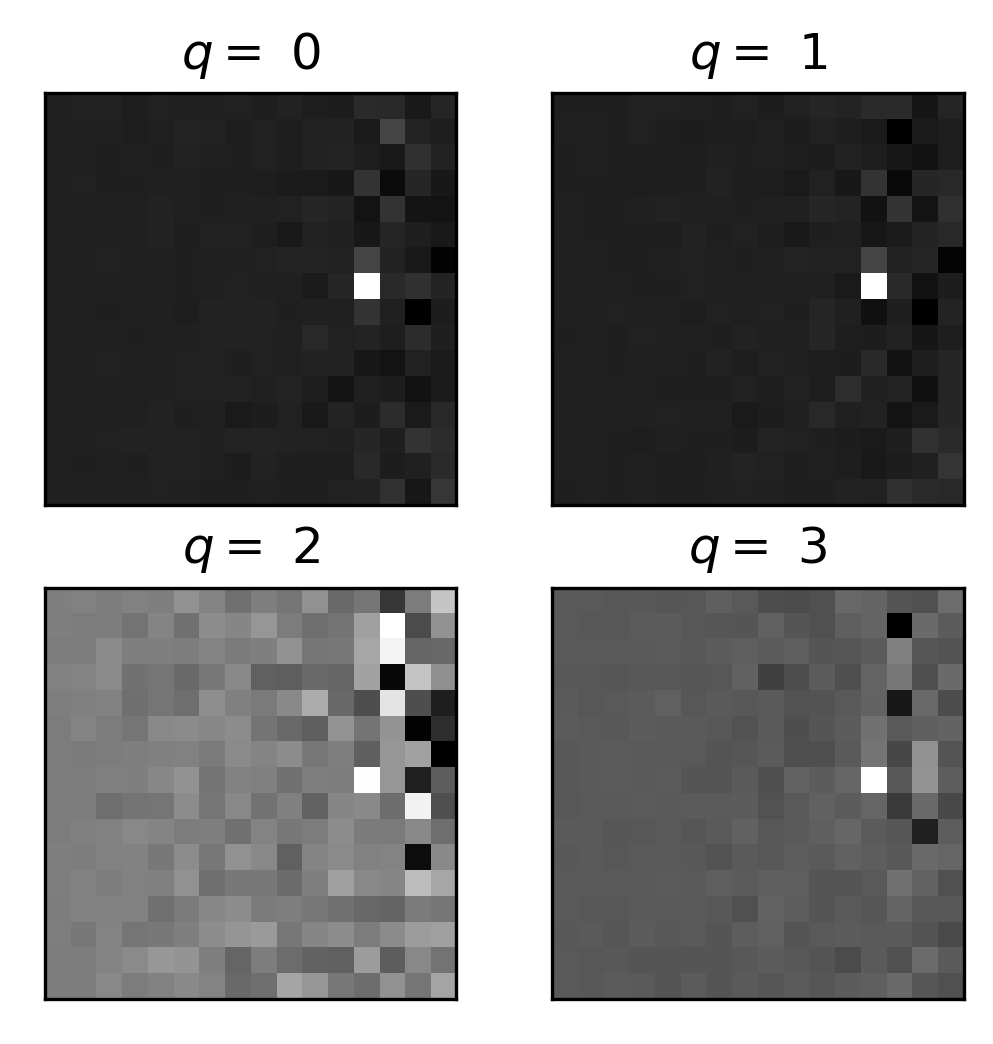

In [274]:
# plt.figure(figsize = (2, 2))
fig, axs = plt.subplots(2, 2, figsize=(4, 4))
for i in range(4):
    ax = axs[i//2, i%2]
    current_threes = threes_hat_list[i]
    img = np.rot90(current_threes[:, 0].reshape(16, 16))
    ax.set_title(r"$q = $ %d" % i)
    ax.imshow(img, cmap="Greys")
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

### PCA, show errors

In [275]:
q_list = np.array([i+1 for i in range(50)])
rmsd_list = []

for i, q in enumerate(q_list):
    threes_hat = assignment3.pca_given_q(threes, q)
    rmsd = assignment3.compute_rmsd(threes, threes_hat)
    rmsd_list.append(rmsd)

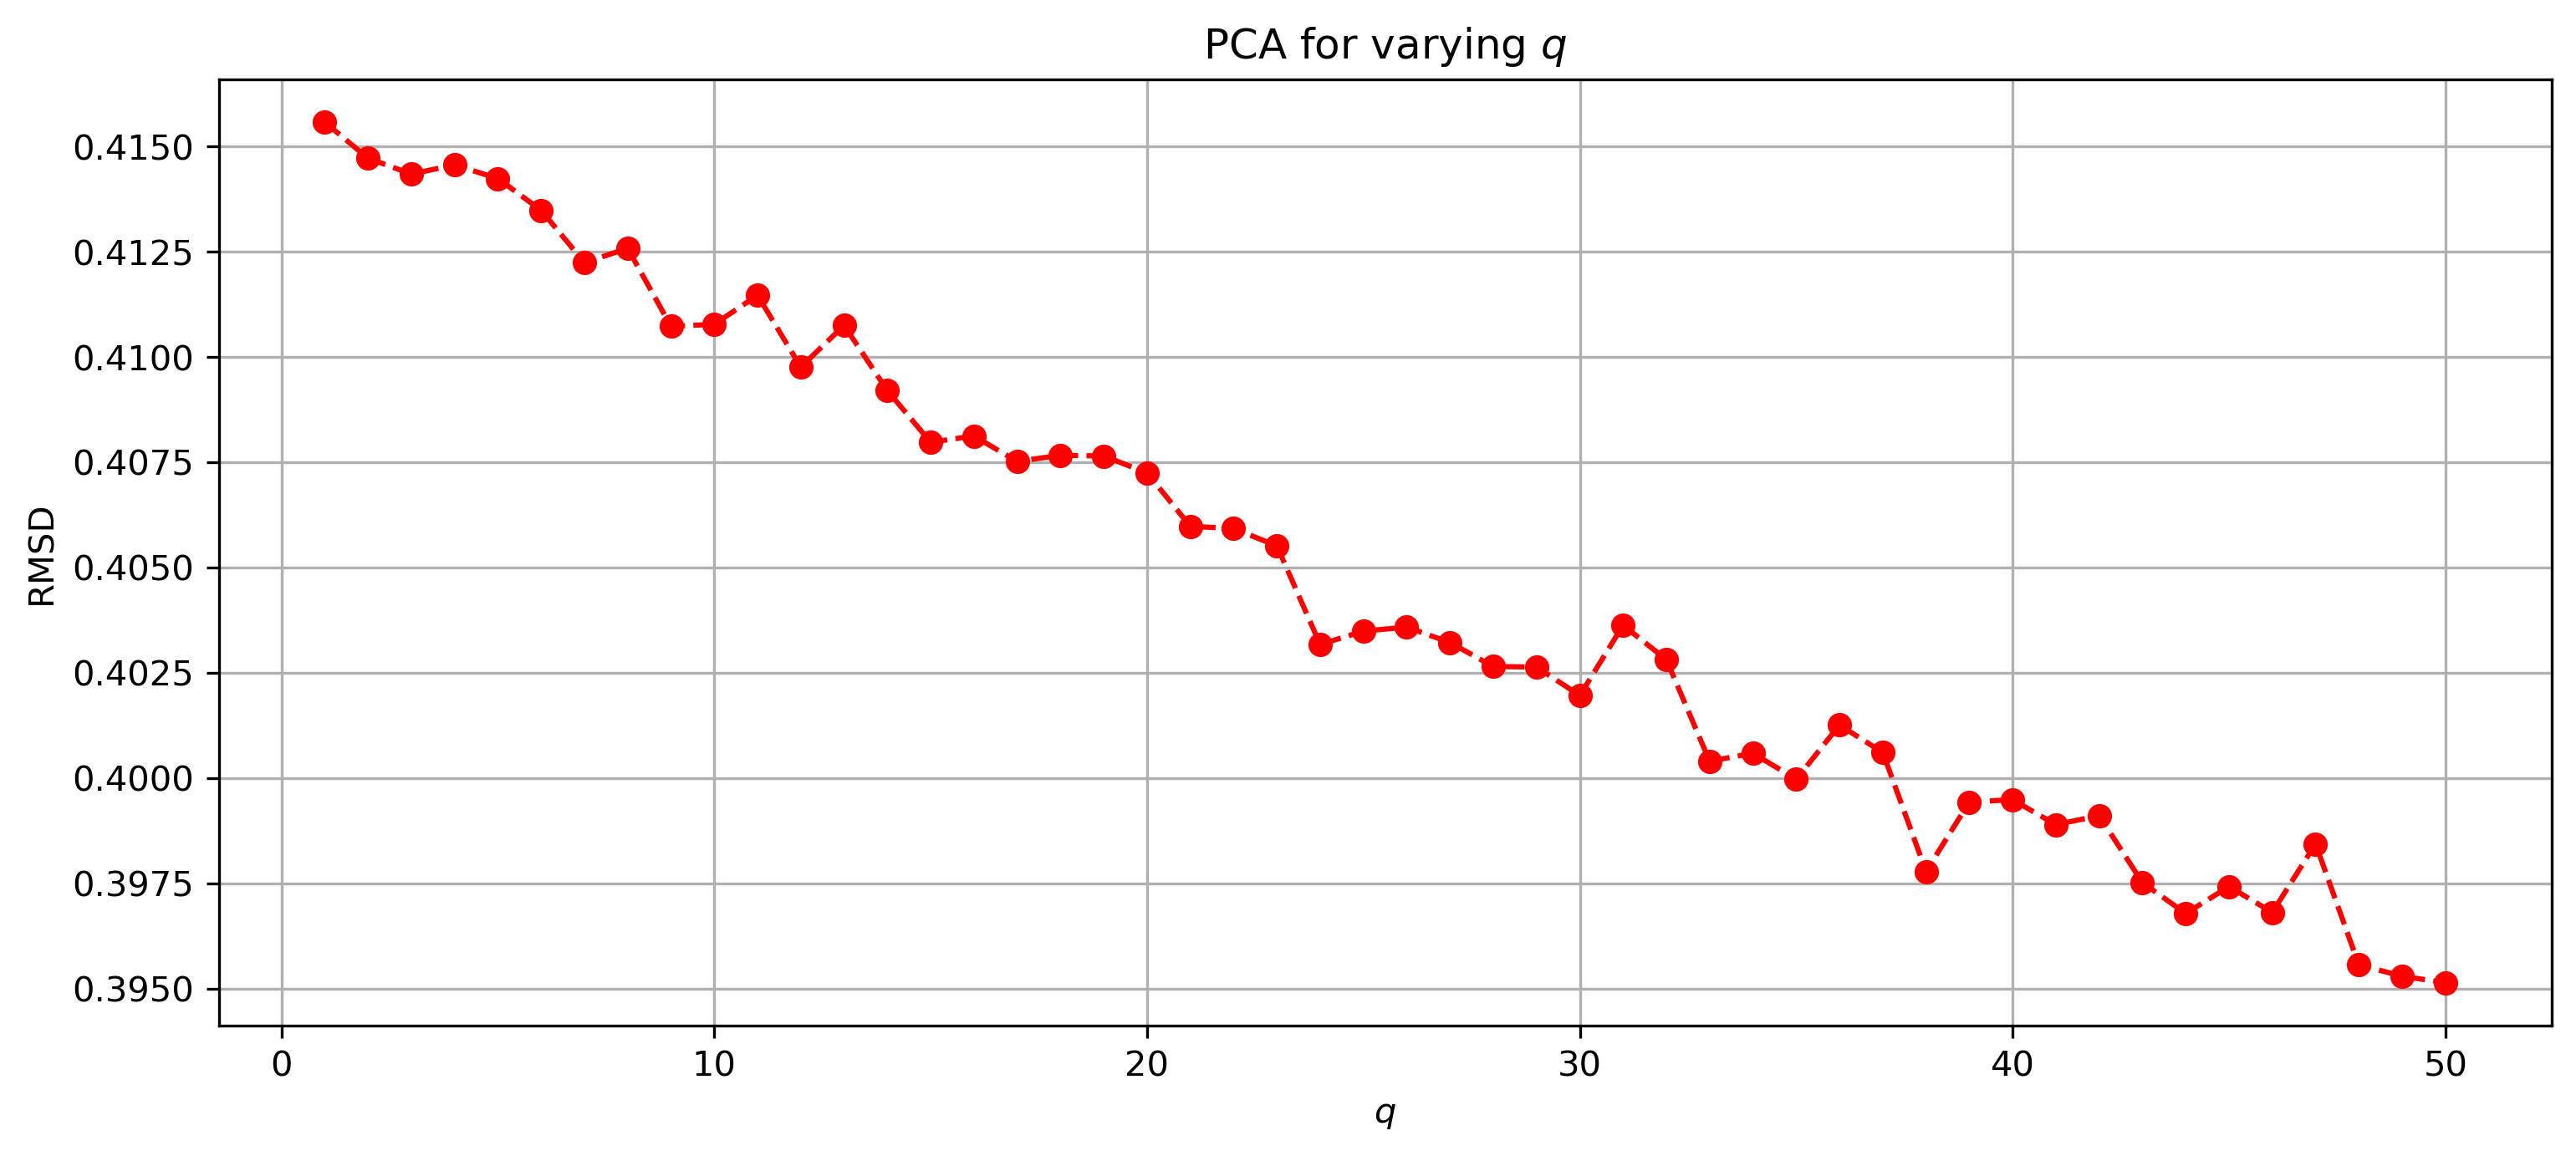

In [276]:
plt.plot(q_list, rmsd_list, '--o', color='red')
plt.grid()
# plt.axhline(rmsd_list[best_index], color='black', alpha=0.5)
# plt.axvline(q_list[best_index], color='black', alpha=0.5)
plt.xlabel(r"$q$")
plt.ylabel("RMSD")
plt.title(r"PCA for varying $q$")
plt.show()

### PCA for $q = 256$

In [277]:
threes_hat = assignment3.pca_given_q(threes, 256)
rmsd = assignment3.compute_rmsd(threes, threes_hat)
print(rmsd)

0.30634162881690363
